In [188]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = False

class DogandCats:
    IMG_SIZE = 50
    CATS = "Pets/Cat"
    DOGS = "Pets/Dog"
    Labels = {CATS:0, DOGS:1}
    
    training_data = []
    
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.Labels:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.Labels[label]]])
                    if label == self.CATS:
                        self.catcount += 1 
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
        np.random.shuffle(self.training_data)
        np.save("traning_data.npy", self.training_data)
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)
        
if REBUILD_DATA:  
    d = DogandCats()
    d.make_training_data()

In [189]:
import os
import cv2
import numpy as np
from tqdm import tqdm


REBUILD_DATA = False # set to true to one once, then back to false unless you want to change something in your training data.

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "Pets/Cat"
    DOGS = "Pets/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()


training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

21370


In [190]:
training_data = np.load("training_data.npy",allow_pickle=True)

In [191]:
training_data[0]

array([array([[ 98, 104,   7, ...,  99,  91,   3],
       [ 92,  89,  28, ..., 101,  92,   5],
       [ 54, 123, 158, ...,  99,  94,   2],
       ...,
       [  0,   0,   0, ...,   0,   2,   8],
       [  0,   0,   0, ...,   0,   4,   4],
       [  0,   0,   0, ...,   0,   5,   3]], dtype=uint8),
       array([1., 0.])], dtype=object)

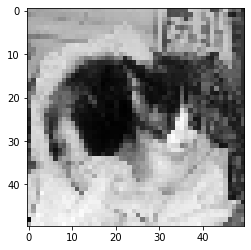

In [192]:
import matplotlib.pyplot as plt
plt.imshow(training_data[1][0], cmap="gray")
plt.show()

In [193]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [194]:
import torch.optim as optim 



X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
#sclae image
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])


VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

2137


In [195]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(train_X))
print(len(test_X))

19233
2137


In [202]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_function = nn.MSELoss()
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

print(f"Epoch: {epoch}. Loss: {loss}")

100%|██████████| 193/193 [00:57<00:00,  3.26it/s]

Epoch: 0. Loss: 0.2447838932275772


In [203]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
    
print("accuracy",  round(correct/total,3))

100%|██████████| 2137/2137 [00:04<00:00, 482.50it/s]

accuracy 0.673


In [204]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the gpu")
else:
    device = torch.device("cpu")
    print("running on the cpu")

running on the gpu


In [205]:
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [206]:
net = Net().to(device)

In [208]:
BATCH_SIZE = 100
EPOCHS = 10
def train(net):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_function = nn.MSELoss()
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
            #print(f"{i}:{i+BATCH_SIZE}")
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i:i+BATCH_SIZE]
            
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.zero_grad()

            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()    # Does the update

        print(f"Epoch: {epoch}. Loss: {loss}")
    
train(net)

  4%|▎         | 7/193 [00:00<00:02, 68.45it/s]

Epoch: 0. Loss: 0.2606494426727295


  4%|▎         | 7/193 [00:00<00:02, 69.80it/s]

Epoch: 1. Loss: 0.22825561463832855


  4%|▎         | 7/193 [00:00<00:02, 67.15it/s]

Epoch: 2. Loss: 0.17491811513900757


  4%|▎         | 7/193 [00:00<00:02, 69.19it/s]

Epoch: 3. Loss: 0.12808294594287872


  4%|▎         | 7/193 [00:00<00:02, 67.99it/s]

Epoch: 4. Loss: 0.10195253044366837


  4%|▎         | 7/193 [00:00<00:02, 69.24it/s]

Epoch: 5. Loss: 0.09897078573703766


  4%|▎         | 7/193 [00:00<00:02, 69.52it/s]

Epoch: 6. Loss: 0.11520791798830032


  4%|▎         | 7/193 [00:00<00:02, 64.08it/s]

Epoch: 7. Loss: 0.07648345828056335


  4%|▎         | 7/193 [00:00<00:02, 66.56it/s]

Epoch: 8. Loss: 0.043923430144786835


100%|██████████| 193/193 [00:03<00:00, 62.52it/s]

Epoch: 9. Loss: 0.02440197765827179


In [211]:
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i])
            net_out = net(test_X[i].view(-1,1,50,50).to(device))[0]
            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1

    print("accuracy",  round(correct/total,3))
test(net)

100%|██████████| 2137/2137 [00:01<00:00, 1392.28it/s]

accuracy 0.741


In [212]:
torch.save(net.state_dict(), "Model")

In [229]:

model = Net()
model.load_state_dict(torch.load("Model"))
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [232]:
net_out = model(test_X[1].view(-1,1,50,50))[0]
predicted_class = torch.argmax(net_out)
print(predicted_class)

tensor(0)


In [228]:
if predicted_class == 1:
    print("heh")

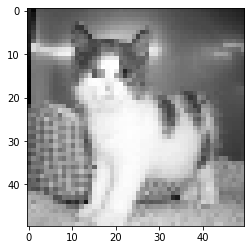

In [223]:
import matplotlib.pyplot as plt
plt.imshow(test_X[1], cmap="gray")
plt.show()